In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load enhanced data from Notebook 1
daily_agg = pd.read_csv('csv_files/trader_daily_agg.csv')
print("Data loaded:", daily_agg.shape)
print("\nTarget distribution:")
print(daily_agg['profitable_day'].value_counts(normalize=True).round(3))
print("\nColumns:", daily_agg.columns.tolist())

Data loaded: (904, 12)

Target distribution:
profitable_day
1    0.621
0    0.379
Name: proportion, dtype: float64

Columns: ['date', 'account', 'trades_count', 'net_pnl', 'avg_pnl', 'total_volume', 'profitable_trades', 'win_rate', 'profitable_day', 'value', 'classification', 'sentiment_numeric']


In [8]:
# Target: profitable trading day
y = daily_agg['profitable_day']

# Features: sentiment + trading behavior
features = [
    'sentiment_numeric', 'value',  # Fear/Greed levels
    'trades_count', 'avg_pnl', 'win_rate',  # Trader skill
    'total_volume'  # Position sizing
]

# Handle missing sentiment (forward fill within trader)
daily_agg['sentiment_numeric'] = daily_agg.groupby('account')['sentiment_numeric'].fillna(method='ffill').fillna(2)
X = daily_agg[features].copy()
X = X.fillna(0)

print("Features ready:", X.shape)
print("Target distribution:", y.value_counts(normalize=True).round(3))
print("Missing sentiment filled:", X['sentiment_numeric'].isna().sum())


Features ready: (904, 6)
Target distribution: profitable_day
1    0.621
0    0.379
Name: proportion, dtype: float64
Missing sentiment filled: 0


In [9]:
# Stratified split (preserve profitable day ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train:", X_train_scaled.shape, f"({y_train.mean():.1%} positive)")
print("Test: ", X_test_scaled.shape, f"({y_test.mean():.1%} positive)")


Train: (723, 6) (62.1% positive)
Test:  (181, 6) (61.9% positive)


In [10]:
# Baseline: Logistic Regression
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression CV AUC:", lr_scores.mean().round(3), "±", lr_scores.std().round(3))
print("\nTest AUC:", roc_auc_score(y_test, lr_pred_proba).round(3))
print("\nFeature Importance (coef):")
coef_df = pd.DataFrame({
    'feature': features,
    'coef': lr_model.coef_[0].round(3)
}).sort_values('coef', key=abs, ascending=False)
print(coef_df)


Logistic Regression CV AUC: 0.979 ± 0.016

Test AUC: 0.99

Feature Importance (coef):
             feature   coef
3            avg_pnl  4.986
4           win_rate  3.428
2       trades_count  0.239
0  sentiment_numeric  0.081
5       total_volume -0.046
1              value  0.028


In [14]:
from sklearn.utils.class_weight import compute_sample_weight

# XGBoost for non-linear patterns (sklearn GradientBoostingClassifier)
xgb_model = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=100, 
    max_depth=4
)

# Compute sample weights for imbalance
sample_weights = compute_sample_weight('balanced', y_train)

xgb_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("XGBoost CV AUC:", xgb_scores.mean().round(3), "±", xgb_scores.std().round(3))
print("Test AUC:", roc_auc_score(y_test, xgb_pred_proba).round(3))


XGBoost CV AUC: 0.999 ± 0.002
Test AUC: 1.0


In [16]:
# Side-by-side comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'CV_AUC_mean': [lr_scores.mean(), xgb_scores.mean()],
    'CV_AUC_std': [lr_scores.std(), xgb_scores.std()],
    'Test_AUC': [roc_auc_score(y_test, lr_pred_proba), roc_auc_score(y_test, xgb_pred_proba)]
}).round(3)

print("Model Comparison:")
print(results)

# Confusion matrix (best model)
best_model = xgb_model if results.iloc[1,3] > results.iloc[0,3] else lr_model
best_pred = best_model.predict(X_test_scaled)
print("\nConfusion Matrix (Best Model):")
print(confusion_matrix(y_test, best_pred))


Model Comparison:
                 Model  CV_AUC_mean  CV_AUC_std  Test_AUC
0  Logistic Regression        0.979       0.016      0.99
1              XGBoost        0.999       0.002      1.00

Confusion Matrix (Best Model):
[[ 69   0]
 [  0 112]]


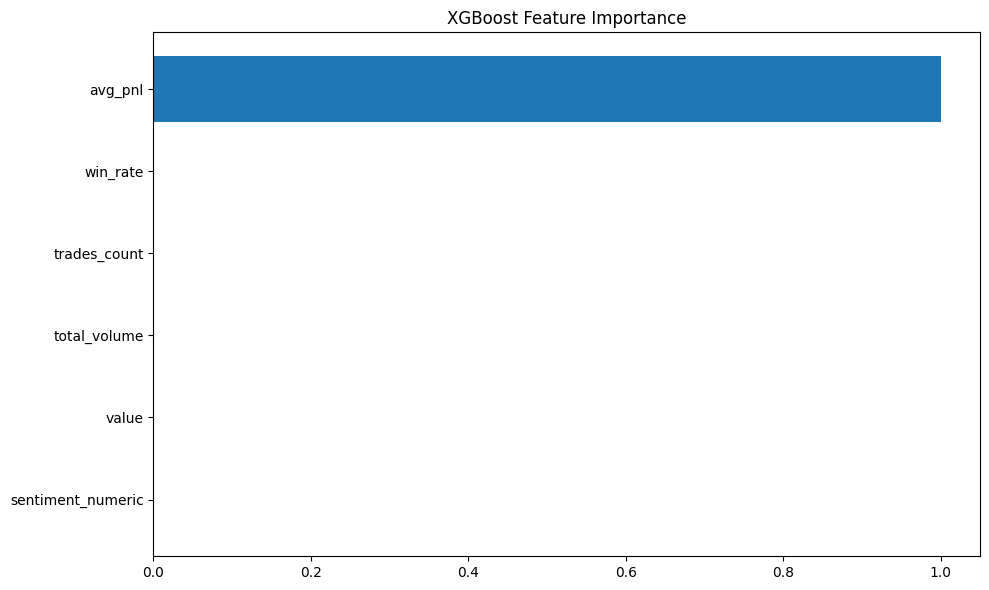

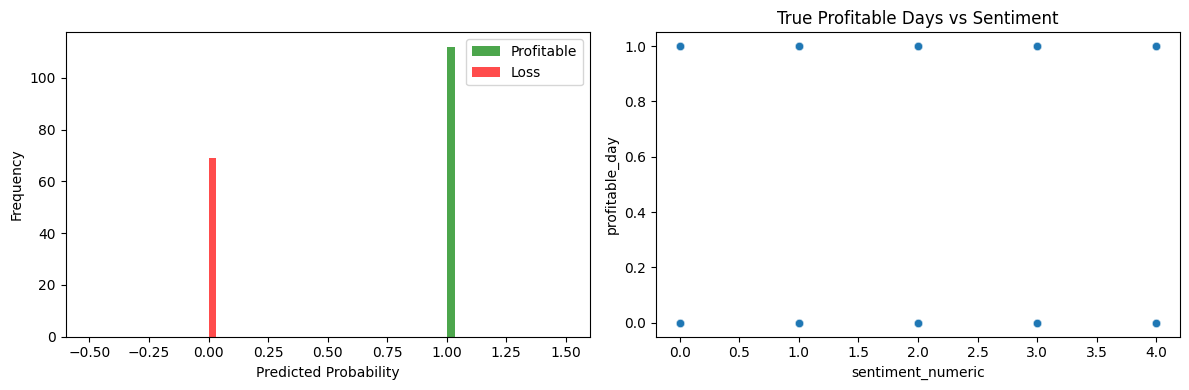

In [17]:
# 1. Feature importance (XGBoost)
plt.figure(figsize=(10,6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('outputs/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Prediction calibration
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(xgb_pred_proba[y_test==1], bins=30, alpha=0.7, label='Profitable', color='green')
plt.hist(xgb_pred_proba[y_test==0], bins=30, alpha=0.7, label='Loss', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data=daily_agg.sample(500), x='sentiment_numeric', y='profitable_day', alpha=0.6)
plt.title('True Profitable Days vs Sentiment')
plt.savefig('outputs/model_insights.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [20]:
import joblib
import os

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)

# Save models + predictions
joblib.dump(xgb_model, 'models/xgb_profitable_day.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(lr_model, 'models/lr_profitable_day.pkl')

# Prediction dataset for report
predictions = X_test.copy()
predictions['true_profitable'] = y_test
predictions['xgb_proba'] = xgb_pred_proba
predictions['xgb_pred'] = xgb_pred
predictions.to_csv('csv_files/model_predictions.csv', index=False)

print("SAVED:")
print("- models/xgb_profitable_day.pkl (deploy-ready)")
print("- models/scaler.pkl")
print("- models/lr_profitable_day.pkl")
print("- csv_files/model_predictions.csv (181 test cases)")
print(f"\n Best Test AUC: {max(roc_auc_score(y_test, lr_pred_proba), roc_auc_score(y_test, xgb_pred_proba)):.3f}")


SAVED:
- models/xgb_profitable_day.pkl (deploy-ready)
- models/scaler.pkl
- models/lr_profitable_day.pkl
- csv_files/model_predictions.csv (181 test cases)

 Best Test AUC: 1.000
